In [9]:
from dataset import load_train
import pandas as pd

In [10]:
data = load_train()
test_data = pd.read_csv("../data/test.csv")

In [3]:
def preprocess_surname(data):
    preds_csv_path = 'surname_predictions.csv'
    preds = pd.read_csv(preds_csv_path, header=None, names=["Surname", "raw_pred"])

    preds["pred_id"] = preds["raw_pred"].str.extract(r"\((\d+),")[0]

    preds = preds[["Surname", "pred_id"]]
    data['Surname_Coutry'] = pd.NA
    preds_dict = preds.set_index('Surname')["pred_id"].to_dict()
    for i in range(len(data)):
        # print(data.at[i, "Surname"], "to", preds_dict[data.at[i, "Surname"]], end= "\n")
        data.at[i, "Surname_Coutry"] = int(preds_dict[data.at[i, "Surname"]])
    # print(data["Surname"])
    data['Surname_Coutry'] = data['Surname_Coutry'].astype(int)
    data.info()
    return data

In [19]:
pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 1.6 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


In [20]:
from rapidfuzz import fuzz, process

unique_surnames = data['Surname'].unique()

# Пример: найти все фамилии, похожие на "Ivanov"
similar = process.extract("Miah", unique_surnames, scorer=fuzz.ratio, limit=10)
print(similar)

[('Miah', 100.0, 585), ('Ma', 66.66666666666667, 399), ('Milani', 60.0, 33), ('Milano', 60.0, 92), ('Mao', 57.14285714285714, 35), ('Mai', 57.14285714285714, 531), ('Maughan', 54.54545454545454, 69), ('Liao', 50.0, 5), ('Hsia', 50.0, 24), ('Milanesi', 50.0, 73)]


In [12]:
data = preprocess_surname(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
 14  Surname_Coutry   15000 non-null  int64  
dtypes: float64(10), int64(2), object(3)
memory usage: 1.7+ MB


In [21]:
unique_surnames = data['Surname'].dropna().unique().tolist()

surname_map = {}

processed = set()

for i, name in enumerate(unique_surnames):
    if name in processed:
        continue
    group = [name]
    for other in unique_surnames[i+1:]:
        if other in processed:
            continue
        score = fuzz.ratio(name, other)
        if score > 60:
            group.append(other)
            processed.add(other)
    for member in group:
        surname_map[member] = name
    processed.add(name)

data['Surname'] = data['Surname'].replace(surname_map)

In [26]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(data['Surname'], data['Exited'])
chi2, p, dof, expected = chi2_contingency(contingency)

print(f'p-value: {p:.4e}')

p-value: 1.8322e-36


In [23]:
country_stats = data.groupby('Surname')['Exited'].agg(
    conversion_rate='mean',
    count='size'
).reset_index().sort_values('conversion_rate', ascending=False)
print(country_stats)


           Surname  conversion_rate  count
336            Wei              1.0      1
312     Titheradge              1.0      1
313      Tobeolisa              1.0      1
19            Bess              1.0      1
278            Pye              1.0      1
..             ...              ...    ...
329  Ugonnatubelum              0.0      1
1        Aikenhead              0.0      2
2          Akeroyd              0.0      1
0           Achebe              0.0      1
362           Zuev              0.0      3

[363 rows x 3 columns]


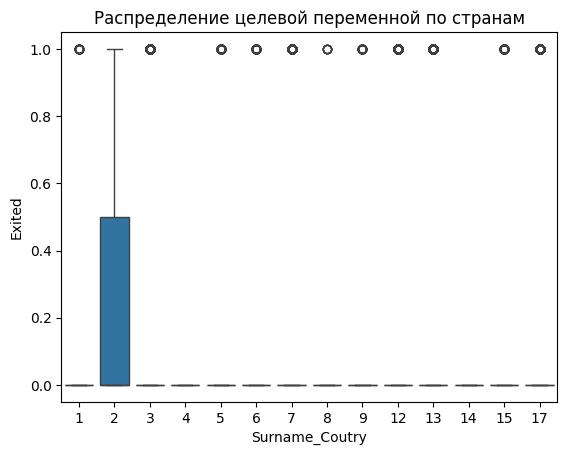

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x='Surname_Coutry', y='Exited', data=data)
plt.title('Распределение целевой переменной по странам')
plt.show()

In [54]:
full_data = pd.concat([data, test_data], ignore_index=True)


In [55]:
data = full_data
data

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15752626.0,Martin,675.0,France,Female,48.0,7.0,143582.89,2.0,0.0,0.0,93844.82,1.0
1,1,15797960.0,Pagnotto,673.0,France,Female,37.0,7.0,0.00,2.0,0.0,0.0,170980.86,0.0
2,2,15672056.0,T'an,607.0,France,Male,29.0,4.0,0.00,2.0,0.0,1.0,61290.99,0.0
3,3,15733169.0,Chukwufumnanya,669.0,France,Female,28.0,2.0,0.00,2.0,1.0,0.0,97734.30,0.0
4,4,15795519.0,Hsing,743.0,France,Male,24.0,7.0,0.00,2.0,1.0,0.0,180800.42,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24995,15575498.0,Chizuoke,705.0,Spain,Female,38.0,8.0,0.00,1.0,0.0,0.0,186489.14,NaN
24996,24996,15709135.0,Iloerika,711.0,Germany,Female,37.0,8.0,117565.03,2.0,1.0,0.0,51112.80,NaN
24997,24997,15752312.0,Wilson,584.0,Germany,Female,43.0,1.0,106804.26,3.0,1.0,0.0,119327.75,NaN
24998,24998,15603035.0,Hs?,652.0,Spain,Male,57.0,3.0,113292.14,1.0,0.0,1.0,44912.60,NaN


In [57]:
len(data["Surname"].unique())

838

In [58]:
list(data["Surname"].unique())

['Martin',
 'Pagnotto',
 "T'an",
 'Chukwufumnanya',
 'Hsing',
 'Liao',
 'Maclean',
 'Lu',
 'Nwachinemelu',
 'Kline',
 'Udinese',
 'Nwabugwu',
 'Nott',
 'Lucciano',
 'Tien',
 'K?',
 'Chidubem',
 'Nwoye',
 'H?',
 'Walker',
 'Houghton',
 'Yermakov',
 'Macintyre',
 'Zetticci',
 'Hsia',
 'Milne',
 'Chukwualuka',
 'Zikoranachidimma',
 "Ch'eng",
 'Ugoji',
 'Lo Duca',
 'Chiazagomekpere',
 'Chibuzo',
 'Milani',
 'Hsiung',
 'Mao',
 'Tuan',
 "Ch'in",
 'Hs?',
 'Nwachukwu',
 'Nnamutaezinwa',
 'Cavenagh',
 'Genovese',
 "T'ang",
 'Onyekachukwu',
 'Chidumaga',
 'Ikedinachukwu',
 'Onuora',
 'Palermo',
 'Chin',
 'Tsou',
 'Onyemauchechukwu',
 'Smith',
 'Lucchese',
 'Nwankwo',
 'Toscani',
 'Lo',
 'Clements',
 "T'ien",
 "Ch'iu",
 'Li Fonti',
 'Chuter',
 "Ts'ui",
 'Nwokezuike',
 'Chiedozie',
 'Chuang',
 'Nwora',
 'Pugh',
 'Hsiao',
 'Maughan',
 "Ts'ao",
 'Chigolum',
 'Ting',
 'Milanesi',
 'Palerma',
 'Chikezie',
 'Kuo',
 'Chukwudi',
 'Shih',
 'Lipton',
 "T'ao",
 'Ugochukwu',
 "Ch'en",
 'Ndubueze',
 'Hsieh',


In [59]:
data["Surname"].sample(25)

16776              Hsia
11755               Hs?
17120    Okwudilichukwu
12092             Brown
21345             T'ien
18980          Chinedum
2033               Chiu
8718             Nnamdi
8840             Hsiung
16105            Farrar
19599        Kenechukwu
6102           Padovano
21241          Chibueze
21069             Hsieh
12421         Udegbunam
3224              Manna
6357               Y?an
7256                 Y?
10874            Chiang
574                P'an
10366          Lucchesi
20116         Okechukwu
24351            Ch'ang
11952           Yobanna
7677      Iweobiegbunam
Name: Surname, dtype: object

In [105]:
data["Surname"].unique()

array(['Martin', 'Pagnotto', "T'an", 'Chukwufumnanya', 'Hsing', 'Liao',
       'Maclean', 'Lu', 'Nwachinemelu', 'Kline', 'Udinese', 'Nwabugwu',
       'Nott', 'Lucciano', 'Tien', 'K?', 'Chidubem', 'Nwoye', 'H?',
       'Walker', 'Houghton', 'Yermakov', 'Macintyre', 'Zetticci', 'Hsia',
       'Milne', 'Chukwualuka', 'Zikoranachidimma', "Ch'eng", 'Ugoji',
       'Lo Duca', 'Chiazagomekpere', 'Chibuzo', 'Milani', 'Hsiung', 'Mao',
       'Tuan', "Ch'in", 'Hs?', 'Nwachukwu', 'Nnamutaezinwa', 'Cavenagh',
       'Genovese', "T'ang", 'Onyekachukwu', 'Chidumaga', 'Ikedinachukwu',
       'Onuora', 'Palermo', 'Chin', 'Tsou', 'Onyemauchechukwu', 'Smith',
       'Lucchese', 'Nwankwo', 'Toscani', 'Lo', 'Clements', "T'ien",
       "Ch'iu", 'Li Fonti', 'Chuter', "Ts'ui", 'Nwokezuike', 'Chiedozie',
       'Chuang', 'Nwora', 'Pugh', 'Hsiao', 'Maughan', "Ts'ao", 'Chigolum',
       'Ting', 'Milanesi', 'Palerma', 'Chikezie', 'Kuo', 'Chukwudi',
       'Shih', 'Lipton', "T'ao", 'Ugochukwu', "Ch'en", 'Ndubuez

In [106]:
surnames = pd.DataFrame({"Surname": data["Surname"].unique()})

# Сохраняем в CSV
surnames.to_csv("names.csv", index=False)

In [62]:
import pandas as pd
import requests
import time

def get_nationalities(surnames, batch_size=10, delay=1.5):
    results = []
    for i in range(0, len(surnames), batch_size):
        batch = surnames[i:i+batch_size]
        query_params = "&".join([f"name[]={name}" for name in batch])
        print(query_params)
        url = f"https://api.nationalize.io/?{query_params}&apikey=70f488dc8f235fc6cdab0825dc65ad52"

        response = requests.get(url)
        if response.status_code != 200:
            print(f"Error for batch {batch[0]}: {response.status_code}")
            continue

        results.extend(response.json())
        time.sleep(delay)
    return results

# Пример
surnames = list(data["Surname"].unique())
results = get_nationalities(surnames)

# Сохраняем
df_nationalities = pd.json_normalize(results, 'country', ['name', 'count'])
df_nationalities.to_csv("surname_nationalities.csv", index=False)


name[]=Martin&name[]=Pagnotto&name[]=T'an&name[]=Chukwufumnanya&name[]=Hsing&name[]=Liao&name[]=Maclean&name[]=Lu&name[]=Nwachinemelu&name[]=Kline
Error for batch Martin: 402
name[]=Udinese&name[]=Nwabugwu&name[]=Nott&name[]=Lucciano&name[]=Tien&name[]=K?&name[]=Chidubem&name[]=Nwoye&name[]=H?&name[]=Walker
Error for batch Udinese: 402
name[]=Houghton&name[]=Yermakov&name[]=Macintyre&name[]=Zetticci&name[]=Hsia&name[]=Milne&name[]=Chukwualuka&name[]=Zikoranachidimma&name[]=Ch'eng&name[]=Ugoji


KeyboardInterrupt: 

In [64]:
len(data["Surname"].dropna().unique())

838

In [101]:
data["Surname"].dropna().unique()[220]

'Trevisani'

In [100]:
import requests
import pandas as pd
import time
import os
API_KEY = 'cd96d8e437c8fbc3807765d5268f1f20'  # 🔁 ← сюда вставь свой ключ
BASE_URL = 'https://v2.namsor.com/NamSorAPIv2'
SAVE_PATH = "surname_nationalities.csv"
def get_nationality(surname):
    url = f"https://v2.namsor.com/NamSorAPIv2/api2/json/origin/last/{surname}"
    headers = {
        "X-API-KEY": API_KEY,
        "Accept": "application/json"
    }
    response = requests.get(url, headers=headers)
    print(response.text)

    if response.status_code == 200:
        result = response.json()
        return {
            "Surname": surname,
            "CountryOrigin": result.get("countryOrigin"),
            "Score": result.get("score"),
            "RegionOrigin": result.get("regionOrigin")
        }
    else:
        print(f"❌ Error {response.status_code} for {surname}")
        return {
            "Surname": surname,
            "CountryOrigin": None,
            "Score": None,
            "RegionOrigin": None
        }


df = pd.read_csv("../data/train.csv")
unique_surnames = data["Surname"].dropna().unique()

if os.path.exists(SAVE_PATH):
    existing_df = pd.read_csv(SAVE_PATH)
    processed_names = set(existing_df["Surname"].unique())
else:
    existing_df = pd.DataFrame()
    processed_names = set()

remaining_names = [name for name in unique_surnames if name not in processed_names]

results = []
for i, name in enumerate(remaining_names, 1):
    res = get_nationality(name)
    if res["RegionOrigin"] == None:
        break
    results.append(res)
    print(f"{i}/{len(remaining_names)} - {res}")
    time.sleep(0.6)
    pd.DataFrame(results).to_csv(SAVE_PATH, mode='a', index=False, header=False)
    results = []



{"script":"LATIN","id":"8aafe4cb-5f89-4b28-ae95-74c1c3da6b70","firstName":"last","lastName":"Hsu","countryOrigin":"TW","countryOriginAlt":"CN","countriesOriginTop":["TW","CN","HK","MM","BN","NA","MW","GH","ID","LR"],"score":14.719968549264802,"regionOrigin":"Asia","topRegionOrigin":"Asia","subRegionOrigin":"Eastern Asia","probabilityCalibrated":0.879852749980935,"probabilityAltCalibrated":0.8838113279730683}
1/728 - {'Surname': 'Hsu', 'CountryOrigin': 'TW', 'Score': 14.719968549264802, 'RegionOrigin': 'Asia'}
{"script":"LATIN","id":"5ab6c495-89df-4eec-9767-003fa46fc6dd","firstName":"last","lastName":"Pisano","countryOrigin":"ZW","countryOriginAlt":"IT","countriesOriginTop":["ZW","IT","BW","MW","TZ","IL","ZM","NA","FR","ID"],"score":7.064679395153411,"regionOrigin":"Africa","topRegionOrigin":"Africa","subRegionOrigin":"Eastern Africa","probabilityCalibrated":0.6853925134011322,"probabilityAltCalibrated":0.8891418904065578}
2/728 - {'Surname': 'Pisano', 'CountryOrigin': 'ZW', 'Score': 7.

In [80]:
results2 = [
    r for r in results
    if r.get("RegionOrigin") not in [None, "None"]
]


In [93]:
len(results2)

96

In [95]:
import os
output_path = "surname_nationalities.csv"

results_df = pd.DataFrame(results2)
results_df.to_csv(output_path, mode='a', index=False, header=not os.path.exists(output_path))
print(f"✅ Добавлено {len(results_df)} записей в {output_path}")

✅ Добавлено 96 записей в surname_nationalities.csv


In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(output_path, mode='a', index=False, header=not os.path.exists(output_path))
print(f"✅ Добавлено {len(results_df)} записей в {output_path}"

In [6]:
te = data.groupby('Surname')['Exited'].mean()
data['Surname_te'] = data['Surname'].map(te)

In [19]:
data['Exited']==1

0         True
1        False
2        False
3        False
4        False
         ...  
14995    False
14996     True
14997    False
14998     True
14999    False
Name: Exited, Length: 15000, dtype: bool

In [6]:
import nbformat
print(nbformat.__version__)


5.10.4


In [42]:
import plotly.express as px
import numpy as np


fig = px.histogram(data["CreditScore"], nbins=50, marginal="box", opacity=1)
fig.update_layout(title="Interactive Distribution Plot")
fig.show()

In [43]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=["Balance", "CreditScore"])

# Первый график: CreditScore
fig.add_trace(
    go.Histogram(x=data["Balance"], nbinsx=30, name="Balance", marker=dict(color='blue')),
    row=1, col=1
)

# Второй график: Age
fig.add_trace(
    go.Histogram(x=data["CreditScore"], nbinsx=30, name="CreditScore", marker=dict(color='green')),
    row=1, col=2
)

# Настройки оформления
fig.update_layout(
    title_text="Распределения: CreditScore и Age",
    showlegend=False,
    width=1000,
    height=400
)

fig.show()


In [44]:
data

,id,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,Surname_te
0,0,Martin,675.0,48.0,7.0,143582.89,2.0,0.0,0.0,93844.82,1.0,False,False,False,0.542373
1,1,Pagnotto,673.0,37.0,7.0,0.00,2.0,0.0,0.0,170980.86,0.0,False,False,False,0.148148
2,2,T'an,607.0,29.0,4.0,0.00,2.0,0.0,1.0,61290.99,0.0,False,False,True,0.090909
3,3,Chukwufumnanya,669.0,28.0,2.0,0.00,2.0,1.0,0.0,97734.30,0.0,False,False,False,0.166667
4,4,Hsing,743.0,24.0,7.0,0.00,2.0,1.0,0.0,180800.42,0.0,False,False,True,0.317073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,Chuang,624.0,37.0,4.0,0.00,1.0,1.0,1.0,91830.75,0.0,False,False,False,0.161290
14996,14996,Udegbulam,796.0,42.0,1.0,132944.01,1.0,1.0,0.0,18922.18,1.0,True,False,False,0.135135
14997,14997,Nwankwo,664.0,24.0,9.0,118098.62,2.0,1.0,1.0,121402.53,0.0,True,False,False,0.219298
14998,14998,Greco,587.0,42.0,6.0,121263.62,1.0,0.0,0.0,119377.44,1.0,True,False,True,1.000000


In [45]:
cat_features = ["Geography", "Gender", "Surname"]
num_features = [col for col in data.columns if col not in cat_features]


In [46]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

n = len(num_features)
n_cols = 2
n_rows = (n + 1) // n_cols

fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=num_features)

for idx, feature in enumerate(num_features):
    row = idx // n_cols + 1
    col = idx % n_cols + 1

    fig.add_trace(
        go.Histogram(x=data[feature], nbinsx=50, name=feature, opacity=1),
        row=row,
        col=col
    )

# Общий вид
fig.update_layout(
    height=300 * n_rows,
    width=1000,
    title_text="Распределения числовых признаков",
    showlegend=False
)

fig.show()


In [47]:
data = data.drop("CustomerId", axis=1)

KeyError: "['CustomerId'] not found in axis"

In [ ]:
data = data.drop("Surname", axis=1)

In [ ]:
data = pd.get_dummies(data, columns=["Geography", "Gender"], drop_first=True)

In [ ]:
data

,id,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,0,Martin,675.0,48.0,7.0,143582.89,2.0,0.0,0.0,93844.82,1.0,False,False,False
1,1,Pagnotto,673.0,37.0,7.0,0.00,2.0,0.0,0.0,170980.86,0.0,False,False,False
2,2,T'an,607.0,29.0,4.0,0.00,2.0,0.0,1.0,61290.99,0.0,False,False,True
3,3,Chukwufumnanya,669.0,28.0,2.0,0.00,2.0,1.0,0.0,97734.30,0.0,False,False,False
4,4,Hsing,743.0,24.0,7.0,0.00,2.0,1.0,0.0,180800.42,0.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,Chuang,624.0,37.0,4.0,0.00,1.0,1.0,1.0,91830.75,0.0,False,False,False
14996,14996,Udegbulam,796.0,42.0,1.0,132944.01,1.0,1.0,0.0,18922.18,1.0,True,False,False
14997,14997,Nwankwo,664.0,24.0,9.0,118098.62,2.0,1.0,1.0,121402.53,0.0,True,False,False
14998,14998,Greco,587.0,42.0,6.0,121263.62,1.0,0.0,0.0,119377.44,1.0,True,False,True


In [ ]:
y = data["Exited"]
X = data.drop("Exited", axis=1)    

In [ ]:
y

0        1.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
14995    0.0
14996    1.0
14997    0.0
14998    1.0
14999    0.0
Name: Exited, Length: 15000, dtype: float64

In [ ]:
sample  = pd.read_csv("../data/sample_submission.csv")

In [ ]:
sample


,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5
...,...,...
9995,24995,0.5
9996,24996,0.5
9997,24997,0.5
9998,24998,0.5
